In [2]:
# Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_
from sqlalchemy import create_engine, func,inspect

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# print column names and types for the station table(you may not need this, seems to still be referring to measurments table)
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print (column['name'], column['type'])
    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# print column names and types for the measurment table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print (column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [ ]:
# Find the most recent date in the data set.
max_recent_date = session.query(func.max(Measurement.date)).scalar()
max_recent_date

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_yr_back = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_yr_back

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
preci_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_yr_back).\
    order_by (Measurement.date).all()

# Save the query results as a Pandas DataFrame 
preci_date_df =pd.DataFrame(preci_data, columns=['date', 'precipitation'])

# Set the index to the date column
preci_date_df.set_index('date', inplace=True)

# Sort the dataframe by date
preci_date_df = preci_date_df.sort_values(by='date')
preci_date_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


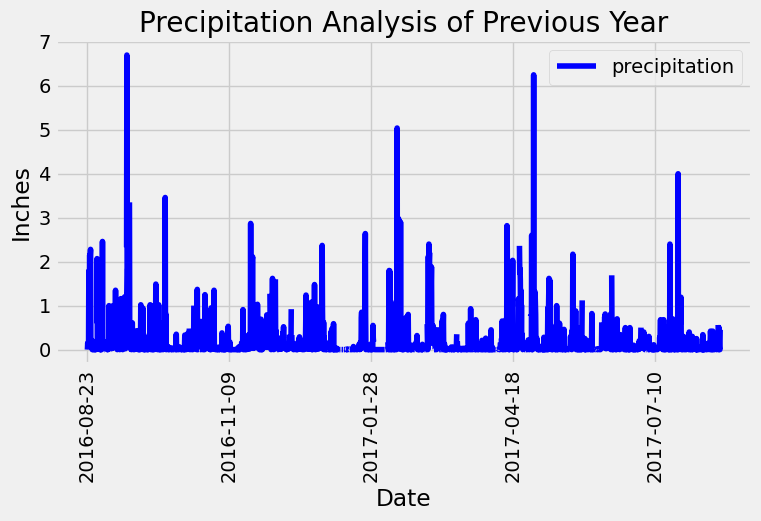

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
plot_prcp_data = preci_date_df.plot(figsize=(8,4), rot=90, color='blue')

plot_prcp_data.set_title('Precipitation Analysis of Previous Year')
plot_prcp_data.set_xlabel('Date')
plot_prcp_data.set_ylabel('Inches')
plot_prcp_data.legend(loc='upper right')

plt.show()

# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
station_count=session.query(Station.station).count()
print(f"Available Stations: {station_count}")

Available Stations: 9


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
list_actv_stations=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
list_actv_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Identify the most active station from the list
most_actv_station=list_actv_stations[0][0]
print(f"Most Active Station: {most_actv_station}")

Most Active Station: USC00519281


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# find the most active station from the list (USC00519281)
most_actv_station=list_actv_stations[0][0]

#calculate the lowest, highest, and average temperature.
temp_obs=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_actv_station).all()
temp_obs


print(f"Temperature Observations for Most Active Station {most_actv_station}")
print(f"Low: {temp_obs[0][0]} High: {temp_obs[0][1]} Average: {round(temp_obs[0][2], 2)}")

Temperature Observations for Most Active Station USC00519281
Low: 54.0 High: 85.0 Average: 71.66


In [21]:
# Using the most active station id (USC00519281)
# Query the last 12 months of temperature observation data for this station
last_yr_tobs = session.query(Measurement.date, Measurement.tobs)\
                    .filter(and_(Measurement.date >= one_yr_back, 
                                 Measurement.station == most_actv_station))\
                    .all()
# Convert to pandas df to plot 
last_yr_tobs = pd.DataFrame(last_yr_tobs)
last_yr_tobs.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


# Close session

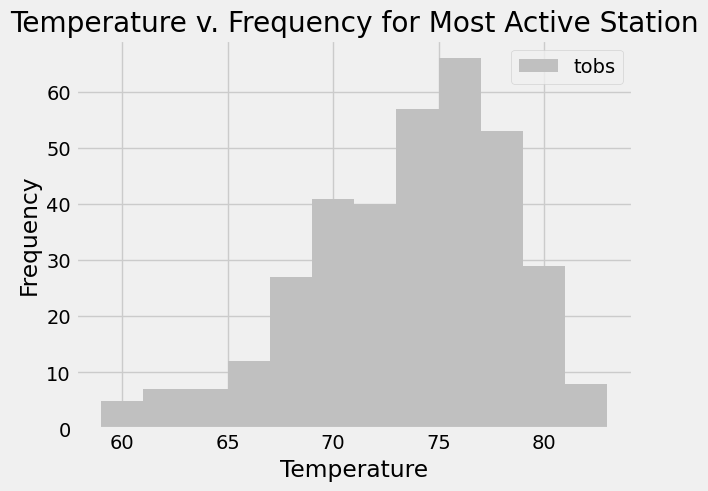

In [24]:
# Plot the results as a histogram
plt.hist(last_yr_tobs['tobs'], bins=12, color='silver')
plt.title('Temperature v. Frequency for Most Active Station')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend(['tobs'])
plt.tight_layout
plt.show()

In [23]:
# Close Session
session.close()